# Computing discharge at Antwerp

## Modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

## Importing data from CSV

### River velocity

In [3]:
rdata = 'D:/Github/PlanktonOfSchelde/data/discharge/'

In [4]:
velos = pd.read_csv(rdata+'Oosterweel-Boven SF_Zeeschelde_panda.csv', delimiter=';', decimal=',')

In [5]:
velos

,Timestamp,Value,Quality Code,Absolute Value,AV Quality Code
0,2023-03-10T00:00:00.000+01:00,0.66,111,NaN,NaN
1,2023-03-10T00:05:00.000+01:00,0.62,111,NaN,NaN
2,2023-03-10T00:10:00.000+01:00,0.56,111,NaN,NaN
3,2023-03-10T00:15:00.000+01:00,0.46,111,NaN,NaN
4,2023-03-10T00:20:00.000+01:00,0.39,111,NaN,NaN
...,...,...,...,...,...
572,2023-03-11T23:40:00.000+01:00,0.58,111,NaN,NaN
573,2023-03-11T23:45:00.000+01:00,0.62,111,NaN,NaN
574,2023-03-11T23:50:00.000+01:00,0.53,111,NaN,NaN
575,2023-03-11T23:55:00.000+01:00,0.50,111,NaN,NaN


In [6]:
Vs = velos.Value

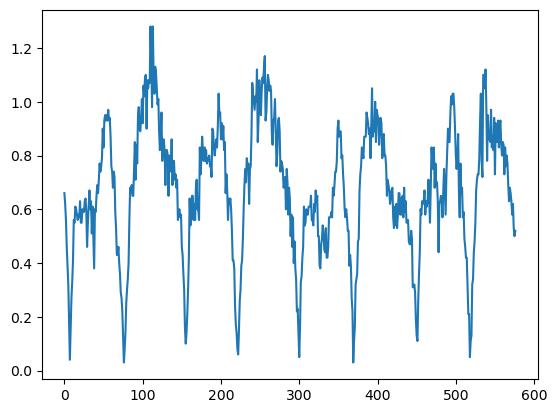

In [7]:
plt.plot(Vs)

### Variation of water level

In [8]:
import xml.etree.cElementTree as ET

In [9]:
tree = ET.ElementTree(file=rdata+'Antwerpen tij_Zeeschelde_Tidal waterlevel.wml2')

In [10]:
dH = []
dHTime = []

for i in tree.iter(tag='{http://www.opengis.net/waterml/2.0}value') :
    for j in i.iter() :
        dH.append(float(j.text))

for i in tree.iter(tag='{http://www.opengis.net/waterml/2.0}time') :
    for j in i.iter() :
        dHTime.append(datetime.datetime.strptime(j.text, '%Y-%m-%dT%H:%M:%S.000+01:00'))

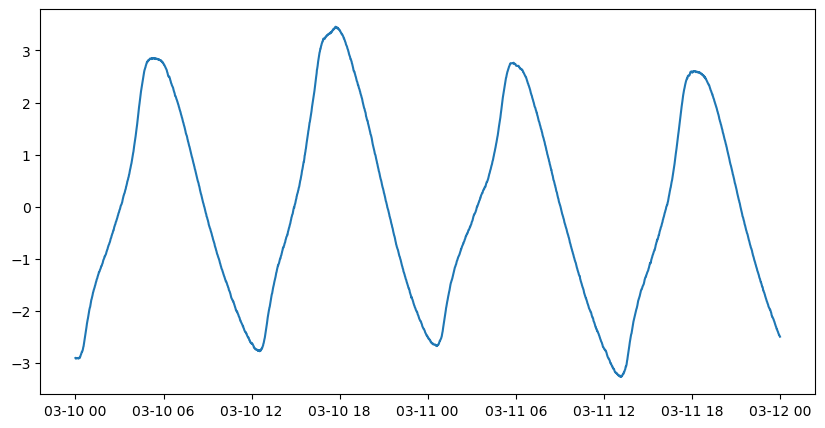

In [11]:
fig = plt.figure(figsize=(10,5))
plt.plot(dHTime,np.array(dH)-np.mean(dH))

### Cross-sectional area of Toffolon,2003


In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
cross = pd.read_csv('./cross-section.csv')
CS = cross['cross-section(m2)']
dist = cross.distance

In [14]:
reg = LinearRegression().fit(np.array([dist]).reshape(-1, 1)  , np.log([CS]).reshape(-1, 1) )

In [15]:
xpred = np.arange(0,80,1).reshape(-1, 1)
pred = reg.predict(xpred)
predCross = np.exp(pred)

Au kilometre 76 la cross-section = 5923.15 m²


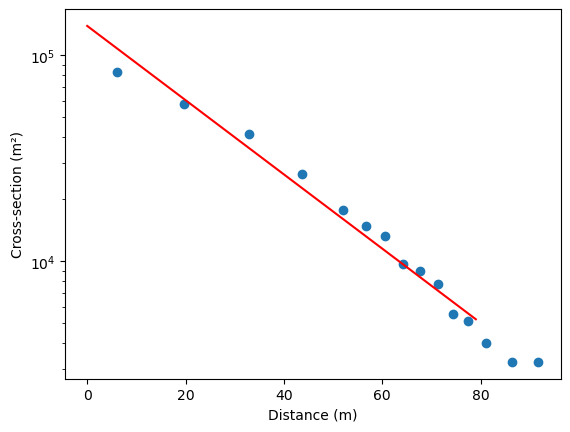

In [16]:
plt.scatter(dist, CS)
plt.plot(xpred,predCross, c='r')
plt.xlabel('Distance (m)')
plt.yscale('log')
plt.ylabel('Cross-section (m²)')
print('Au kilometre %i la cross-section = %.2f m²' %(xpred[76][0], predCross[76][0]))

## Computing discharge without dH
Q = A*Vs

In [37]:
A = predCross[76][0] #Toffolon, 2003
Q = A*Vs
np.min(Q)

177.6944111648312

Text(2023-03-11 09:20:00, 7000, 'Q$_{mean}$ = 296.16 m$^3$/s $\\pm$ 168.67')

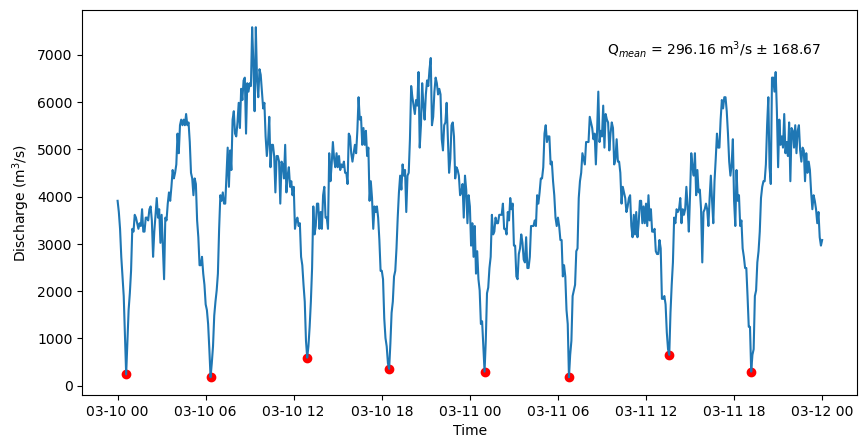

In [38]:
dt = 24*60/4
dt /= 5
lQ = []
lTimeQ = []

fig = plt.figure(figsize=(10,5))

for i in range(len(Q)) :
    st = datetime.datetime(2023,3,10,0,0)
    lTimeQ.append(st + datetime.timedelta(minutes=i*5))
plt.plot(lTimeQ,Q)
plt.xlabel('Time')
plt.ylabel('Discharge (m$^3$/s)')

lminTimeQ = []
for i in range(int(len(Q)/dt)) :
    minQ = np.min(Q[int(i*dt):int(dt+(i*dt))])
    argQ = int(i*dt) + np.argmin(Q[int(i*dt):int(dt+(i*dt))])
    lQ.append(minQ)
    lminTimeQ.append(lTimeQ[argQ])
    
plt.scatter(lminTimeQ, lQ,c='r')

plt.text(lTimeQ[400],7000, 'Q$_{mean}$ = %.2f m$^3$/s $\pm$ %.2f' %(np.median(lQ), np.std(lQ)))

### Computing discharge with dH

In [39]:
condi = np.in1d(np.array(dHTime),np.array(lTimeQ))

In [40]:
extdHTime = np.extract(condi, dHTime)
extdH = np.extract(condi,dH)

In [62]:
A = predCross[76][0] #Toffolon, 2003
dHQ = (A+(extdH-np.mean(extdH))*420)*Vs

In [63]:
ldHQ = []
lminTimedHQ = []
for i in range(int(len(Q)/dt)) :
    mindHQ = np.min(dHQ[int(i*dt):int(dt+(i*dt))])
    argdHQ = int(i*dt) + np.argmin(dHQ[int(i*dt):int(dt+(i*dt))])
    ldHQ.append(mindHQ)
    lminTimedHQ.append(lTimeQ[argdHQ])

Text(0, 0.5, 'Discharge (m$^3$/s)')

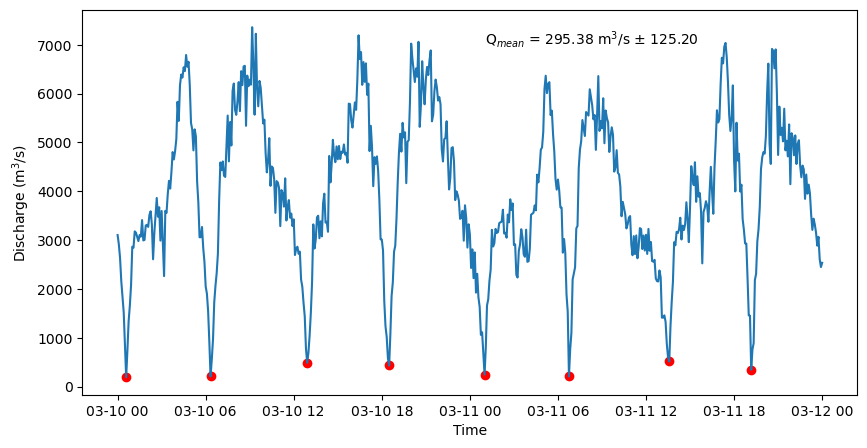

In [64]:
fig = plt.figure(figsize=(10,5))
plt.plot(lTimeQ,dHQ)
#plt.plot(dHTime,(np.array(dH)-np.mean(dH))*1000+5000,c='orange',ls='--')
plt.scatter(lminTimedHQ, ldHQ,c='r')
plt.text(lTimeQ[300],7000, 'Q$_{mean}$ = %.2f m$^3$/s $\pm$ %.2f' %(np.median(ldHQ), np.std(ldHQ)))
plt.xlabel('Time')
plt.ylabel('Discharge (m$^3$/s)')

7